<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/ECoG/load_ECoG_fingerflex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/projects/ECoG/load_ECoG_fingerflex.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

## Loading of Miller ECoG data of the finger flexing task

includes some visualizations

In [ ]:
# @title Data retrieval
import os, requests

fname = 'fingerflex.npz'
url = "https://osf.io/5m47z/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Install packages, import matplotlib and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

# Select just one of the recordings here. This is subject 1, block 1.
dat = alldat[0][0]

print(dat.keys())

dict_keys(['V', 'dg', 't_on', 't_off', 'stim_id', 'stimtext', 'srate', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


# Dataset info #

This is one of multiple ECoG datasets from Miller 2019, recorded in clinical settings with a variety of tasks. Raw data here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522


This particular dataset has been used in the following publications:

*Miller, Kai J., et al. "Decoupling the cortical power spectrum reveals real-time representation of individual finger movements in humans." Journal of Neuroscience 29.10 (2009): 3132-3137.*

*Miller, Kai J., et al. "Human motor cortical activity is selectively phase-entrained on underlying rhythms." (2012): e1002655.*

`alldat` contain 3 sessions from 3 subjects, and was used in this paper: 

https://pubmed.ncbi.nlm.nih.gov/17873429/

From the dataset readme: 

*finger movement task, subjects were cued with a word displayed on a bedside monitor indicating which finger to move during 2- second movement trials. The subject performed self-paced movements in response to each of these cues, and they typically moved each finger 2–5 times during each trial, but some trials included many more movements.
"stim" (time x 1):
0 – Inter-stimulus interval
1 – thumb
2 – index finger
3 – middle finger 
4 – ring finger
5 – little finger*

The motion of the fingers was captured with a dataglove, which was sampled at the same rate (1000Hz) as the voltage data. From the dataset readme: 

*finger flexions, measured from the hand contralateral to grid placement. Note that they are in the raw form input. They are in 40ms blocks, and have non-zero offset. The 5 columns correspond to the digits thumb-index-middle-ring-little in order. Finger positions were recorded using a 5 degree-of-freedom dataglove sensor (5 dt, Irvine, CA).*

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across the entire recording and conversion to float16 to minimize size (please convert back to float32 for analysis). 

Variables are: 
* `dat['V']`: continuous voltage data (time by channels)
* `dat['locs`]: three-dimensional coordinates of the electrodes (n_channels by 3)
* `dat['dg']`: digit flexions (time x number of fingers). This was preprocessed from the original data to remove a moving baseline. 
* `dat['srate']`: sampling rate (always 1000)
* `dat['t_on']`: time of cue onset 
* `dat['t_off']`: time of cue offset (usually 2000ms after `t_on`) 
* `dat['stim_id']`: cue identity (which finger to flex)
* `dat['stimtext']`: cue text on the screen 


In [ ]:
from nilearn import plotting
from nimare import utils

plt.figure(figsize=(8, 8))
locs = dat['locs']
view = plotting.view_markers(utils.tal2mni(locs), marker_labels  = ['%d'%k for k in np.arange(locs.shape[0])], marker_color = 'purple', marker_size=5)
view

/opt/hostedtoolcache/Python/3.7.12/x64/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


<Figure size 576x576 with 0 Axes>

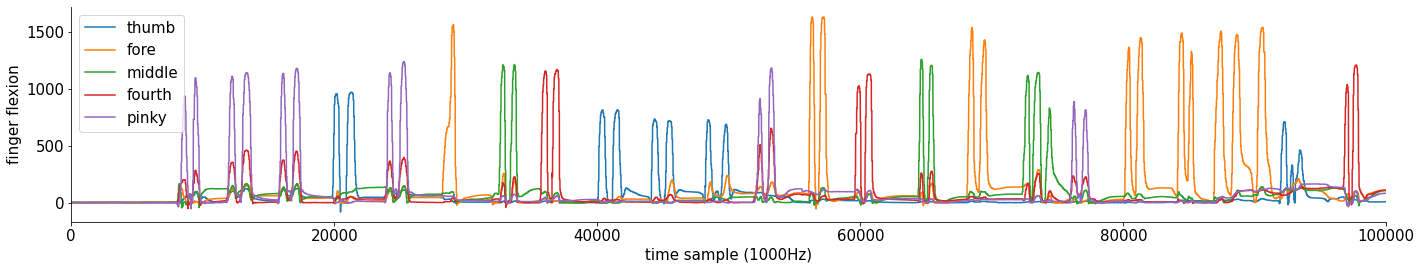

In [ ]:
# finger data from the dataglove
dg = dat['dg']
nfingers = dg.shape[1]

for j in range(dg.shape[-1]):
  plt.plot(dg[:100000, j])

plt.xlabel('time sample (1000Hz)')
plt.ylabel('finger flexion')
plt.xlim([0, 100000])
plt.legend(dat['stimtext'])

Text(0, 0.5, 'finger flexion')

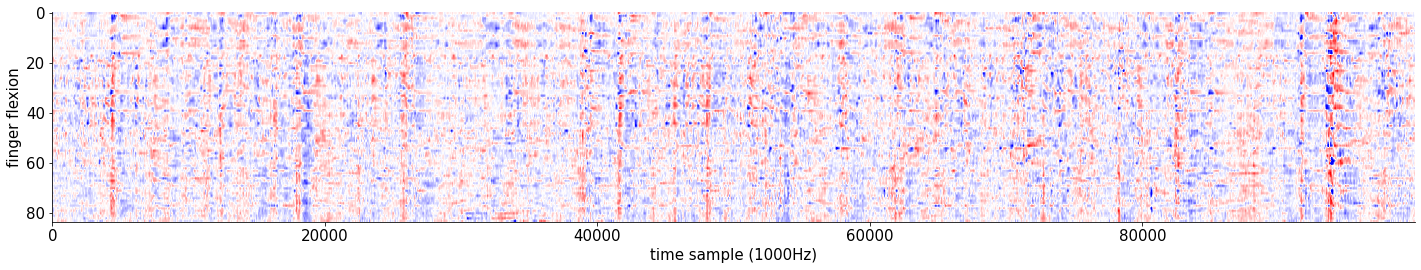

In [ ]:
# voltage data in the same time period
V = dat['V'].astype('float32')
plt.imshow(V[:100000, :].T, aspect = 'auto', vmax = 4, vmin = -4, cmap = 'bwr')

plt.xlabel('time sample (1000Hz)')
plt.ylabel('finger flexion')

In [ ]:
# compute correlations between high frequency band and each digit
from scipy import signal

V = dat['V'].astype('float32')
b, a = signal.butter(3, [50], btype='high', fs=1000)
V = signal.filtfilt(b,a,V,0)
V = np.abs(V)**2
b, a = signal.butter(3, [3], btype='low', fs=1000)
V = signal.filtfilt(b,a,V,0)

nt, nchan = V.shape

cc = np.zeros((nchan,nfingers))
for j in range(nchan):
  for k in range(nfingers):
    cc[j, k] = np.corrcoef(V[:,j], dg[:,k])[0, 1]

Text(0, 0.5, 'fingers')

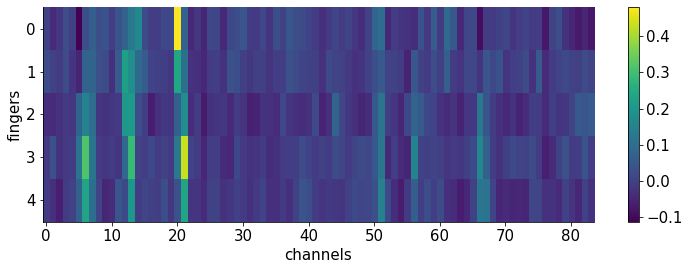

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(cc.T, aspect='auto')
plt.colorbar()
plt.xlabel('channels')
plt.ylabel('fingers')

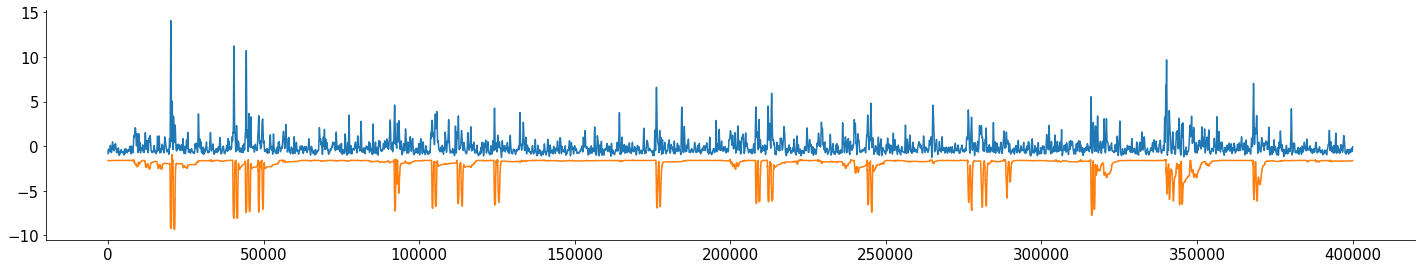

In [ ]:
# looks like electrode 20 is well correlated with finger 0 (the thumb). Let's check out the timecourses.
# interestingly, we see that many thumb flexions are indeed correlated with this electrode, but there are other events too

from scipy.stats import zscore
plt.plot(zscore(V[:400000,20]))
plt.plot(-2-zscore(dg[:400000,0]))

In [ ]:
# needs more plots!
# looks like only spectral information above 50Hz is useful, but I might be missing something.